# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [10]:
#cloning git rep for dataset
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

fatal: destination path 'Coursera-Content' already exists and is not an empty directory.


In [11]:
!pip install -q keras

In [12]:
!pip install -U scikit-learn

## Import necessary Libraries

In [13]:
import os
import random
from tqdm import tqdm #smart progress bar for loops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #dataVisualizaton lib
import cv2
from IPython.display import Image
import imutils  #series of funcs for basic img processing

from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report
#plot_confusion_matrix
#plot_confusion_matrix is in depricated version of sklearn.metrics 1.0 , so error
#ConfusionMatrixDisplay is in the latest verison 1.2

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils

## Creating Directories to store Cropped Images

In [14]:

#create directory for training data
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI/glioma_tumor')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI/no_tumor')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI'

In [15]:
# #create directory for testing data
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Test-Data')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Test-Data/glioma_tumor')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Test-Data/meningioma_tumor')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Test-Data/pituitary_tumor')
os.mkdir('C:/Users/Asus/Desktop/Brain Tumor/Test-Data/no_tumor')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/Asus/Desktop/Brain Tumor/Test-Data'

## Data Visualization

In [16]:
#specify directory
train_dir = 'C:/Users/Asus/Desktop/Brain Tumor/Coursera-Content/Brain-MRI/Training/'
test_dir = 'C:/Users/Desktop/Brain Tumor/Coursera-Content/Brain-MRI/Testing/'

In [17]:
#create classes
#python os moudle command to get all the files and dirs in a specifiedd dir
#here takes the folder names as claasses
classes = os.listdir('C:/Users/Asus/Desktop/Brain Tumor/Coursera-Content/Brain-MRI/Training')

In [18]:
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

Creates a dictionary "files_path_dict" whose 4 elements are the classes c, and each class c is iterable.
So map(func(lambda),iterable(c)) here it creates a list of pictures(os.listDir) for each iterable element c, and puts all in the list form. mainly creates a list for each element of the dict..
lambda x: x is the argument of the lambda func

In [19]:
files_path_dict = {} #python set/dictionary


for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))
  print(c)
#files_path_dict

glioma_tumor
meningioma_tumor
no_tumor
pituitary_tumor


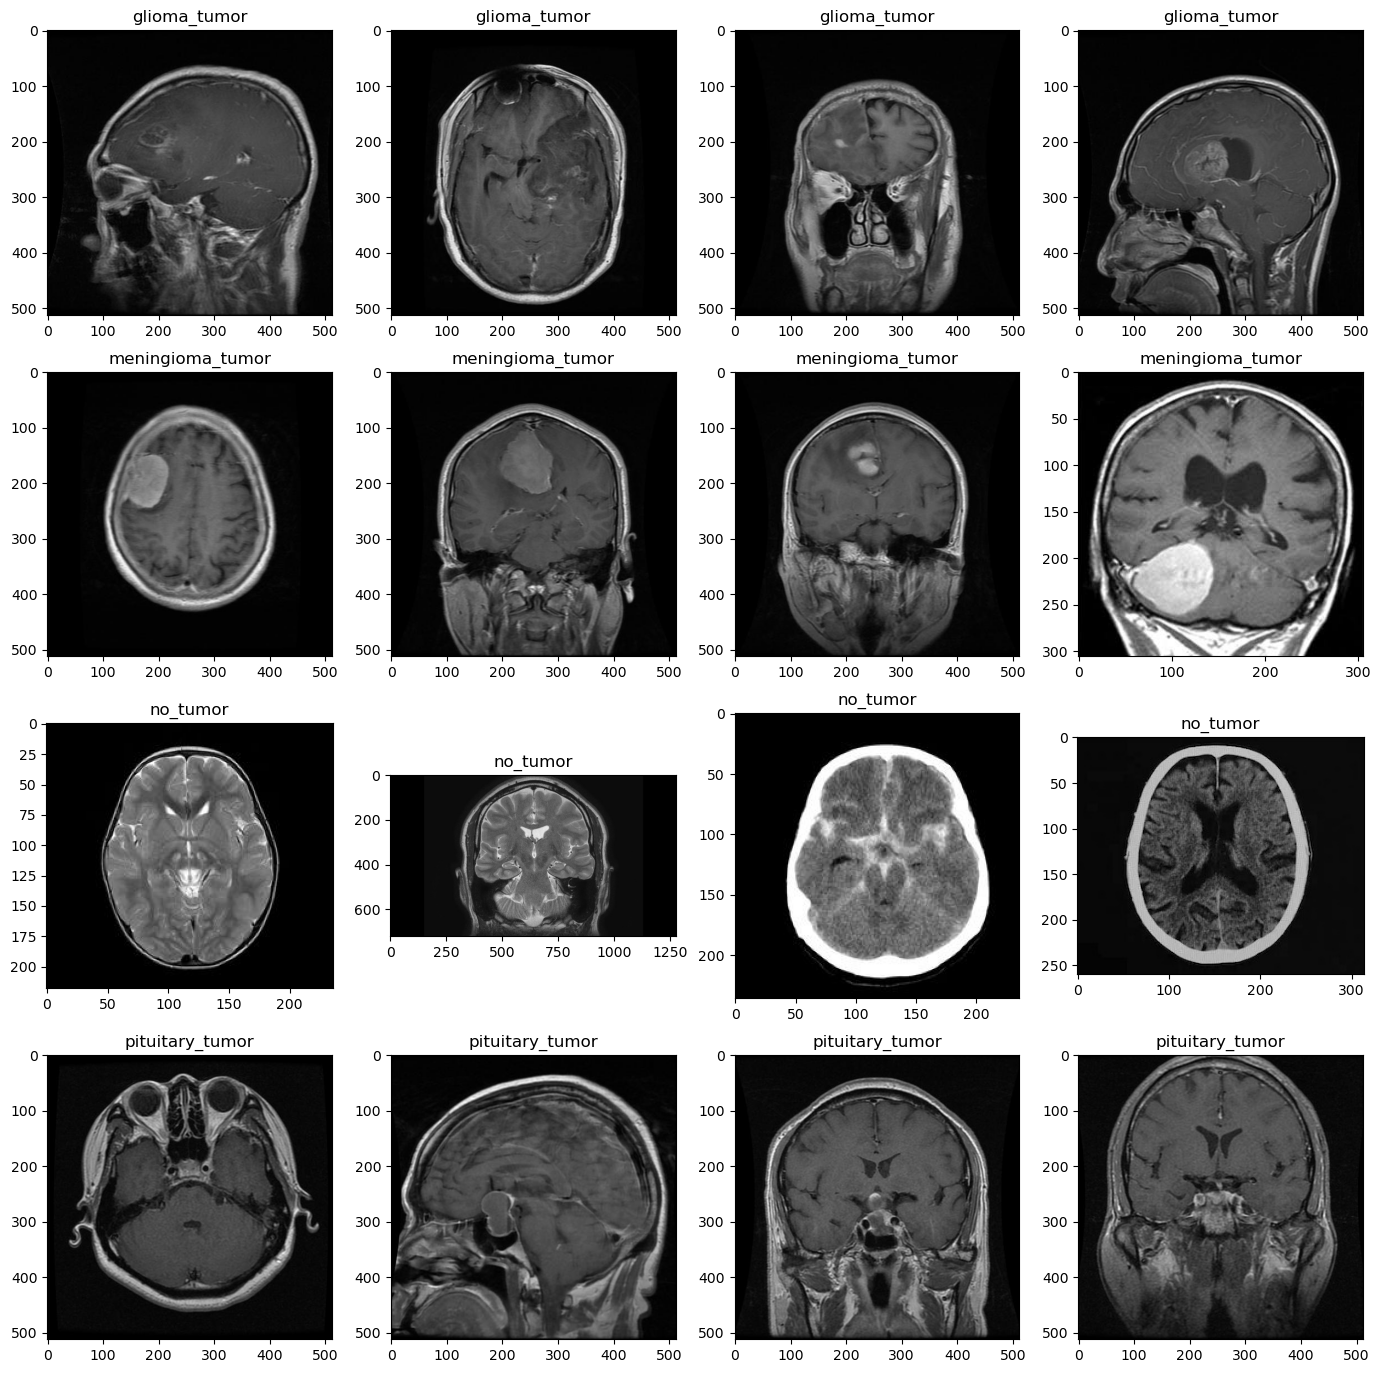

In [20]:
plt.figure(figsize = (17,17)) #changes h,w of the plot
index = 0
for c in classes: #iterates thru class - 4 time iter
  random.shuffle(files_path_dict[c])# randomly select a class
  path_list = files_path_dict[c][:5] # the dict element's first 5 pics path stored in path_list list

  #for each class c iter this loop 4 times prints 4 pics of the same class
  for i in range(1, 5): #1~4
    index += 1
    plt.subplot(4, 4, index) #nrows,ncols and index is nth suplot like index =1 means 1st subplot
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [21]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('C:/Users/Asus/Desktop/Brain Tumor/Coursera-Content/Brain-MRI/Training'):
  #basically enters the brainMRi/training/each class foler (i)
  train_class = os.listdir(os.path.join('C:/Users/Asus/Desktop/Brain Tumor/Coursera-Content/Brain-MRI/Training', i))
  #and then counts num of images of each class in each iter and stores in list
  No_images_per_class.append(len(train_class))
  #and class/ folder name in diff list and prints both
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in glioma_tumor = 926 

Number of images in meningioma_tumor = 937 

Number of images in no_tumor = 501 

Number of images in pituitary_tumor = 901 



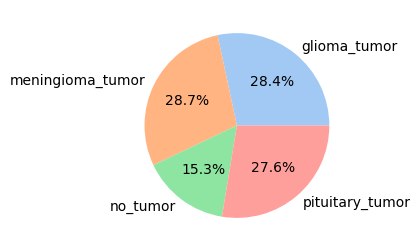

In [22]:
#visualize class distribution in train set
plt.figure(figsize=(3, 3))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class,
        labels = Class_name,
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

## Create a Function to Crop Images

In [23]:
#crop image to only the subject and avoid dblack areas
def crop_image(image, plot=False):

    #here all are  image processing concepts : gray,blur,binThres,erosion,dialation,contour
    #image -->gray--blur-->er-->dial-->ImgShape(morphology)
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    #apply binary threshhold: either 0 or 1
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours / outline or boundary
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    #axis: 0--> rows 1--> cols
    #extraction of the boundary of the shape
    #argmin :returns the val of the min index along an axis

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #generate new image
    #image[h,w] also opencv
    #1,0 axis related
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    #plot
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


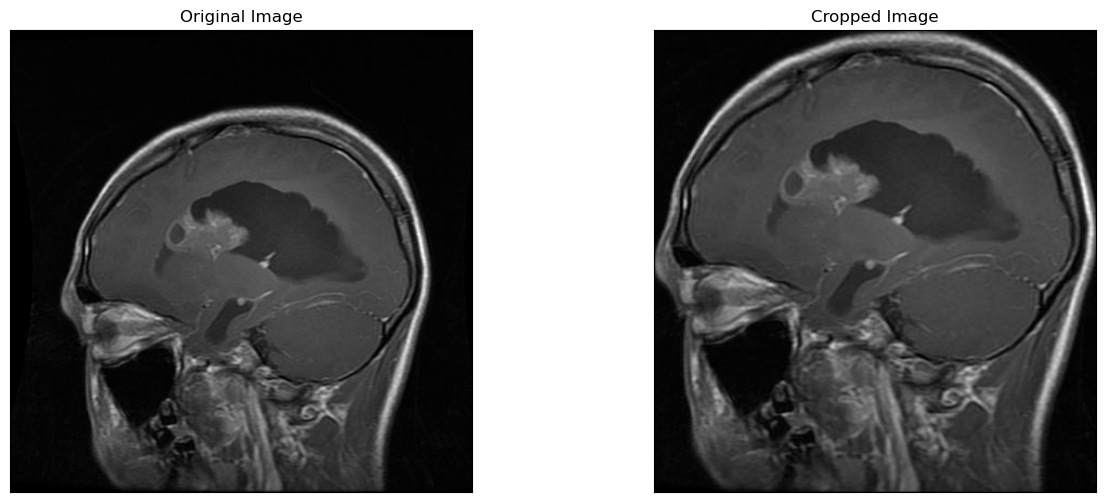

In [24]:
example_image = cv2.imread('C:/Users/Asus/Desktop/Brain Tumor/Coursera-Content/Brain-MRI/Training/glioma_tumor/gg (60).jpg')
cropped_image = crop_image(example_image, plot=True)


## Saving The Cropped Images

In [25]:
#crop training images and save it to the directory we previously created
glioma = train_dir + 'glioma_tumor'
meningioma = train_dir + 'meningioma_tumor'
pituitary = train_dir + 'pituitary_tumor'
no_tumor = train_dir + 'no_tumor'

j = 0
#reads image from folder and sends to crop image func
for i in tqdm(os.listdir(glioma)): #progressbar tqdm
  path = os.path.join(glioma, i) #selects each image
  img = cv2.imread(path)
  img = crop_image(img, plot=False) #crops

  if img is not None: #img cropped successfully then
    img = cv2.resize(img, (240, 240))
    #saves image to new foLder
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/data/train/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg' #j is numbreing image renameing
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/data/train/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/data/train/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/data/train/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 501/501 [00:01<00:00, 280.61it/s]


In [26]:
#crop testing images and save it to the directory we previously created
test_glioma = test_dir + 'glioma_tumor'
test_meningioma = test_dir + 'meningioma_tumor'
test_pituitary = test_dir + 'pituitary_tumor'
test_no_tumor = test_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/Test-Data/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/Test-Data/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/Test-Data/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/Asus/Desktop/Brain Tumor/Test-Data/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/Desktop/Brain Tumor/Coursera-Content/Brain-MRI/Testing/glioma_tumor'

## Data Augmentation

In [27]:
#use Image Data Generator to perform this task
#train set
#data aug: flip, rotate , etc , // regularization
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('C:/Users/Asus/Desktop/Brain Tumor/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
#dont need any aug for testing
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('C:/Users/Asus/Desktop/Brain Tumor/Test-Data/',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [28]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


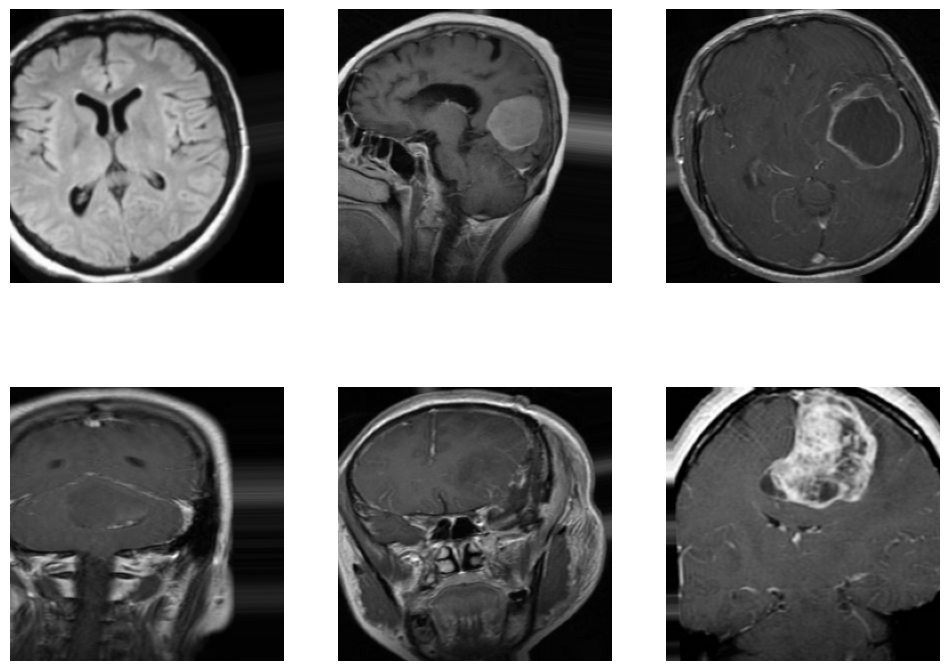

In [29]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
#print any 6 images from train data
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Model Architect

In [30]:
#build the model
#included pre build models : tensor
effnet = EfficientNetB1(weights='imagenet',
                        include_top=False,
                        input_shape=(240, 240, 3))

model1 = effnet.output
model1 = GlobalAveragePooling2D()(model1)
model1 = Dropout(0.5)(model1)
model1 = Dense(4, activation='softmax')(model1)
model1 = Model(inputs=effnet.input,
              outputs=model1)

#get summary()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['normalization[0][0]']      

In [31]:
pip install pydot


Note: you may need to restart the kernel to use updated packages.


In [32]:
from keras.utils.vis_utils import plot_model

#plot
plot_model(model1, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Compile Model

In [38]:
#compile model
model1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
#saves model weights at some points
# checkpoint = ModelCheckpoint('model.h5',
#                              monitor='val_accuracy',
#                              save_best_only=True,
#                              mode='auto',
#                              verbose=1)

#early stopping
#stop when performance stopped improving
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
#reduce learning rate when model stopped improving
#hill clibling algo - plateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

## Model Training and Model Evaluation

In [ ]:
%%time

#train the model
#verbose : makes more readable
history = model1.fit(train_data,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/30
16/82 [====>.........................] - ETA: 20:58 - loss: 0.2004 - accuracy: 0.9375

## Model Evaluation

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

In [ ]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

In [ ]:
y_test

In [ ]:
yhat_test

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot #normalize = 0~1
plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
#get classification report
print(classification_report(y_test, yhat_test))

## Obtaining Predictions on Test Images

In [ ]:
import PIL

class_dict = {0: 'glioma_tumor',
              1: 'meningioma_tumor',
              2: 'no_tumor',
              3: 'pituitary_tumor'}

prediction = []
original = []
image = []
count = 0

for i in os.listdir('/content/Test-Data/'): #iter 4 classes
  for item in os.listdir(os.path.join('/content/Test-Data', i)): #iter all imgs in each class
    # code to open the image
    img= PIL.Image.open(os.path.join('/content/Test-Data', i, item))
    #append to image list
    image.append(img)
    #expand dimension
    img = np.expand_dims(img, axis=0) #expans dimen
    #predict
    predict = model.predict(img) #inbuilt
    #get the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #append the predicted class to the list
    prediction.append(class_dict[predict]) #predicted
    #append original class to the list
    original.append(i) # original

In [ ]:
#test accuracy
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

In [ ]:
#visualize the results
fig = plt.figure(figsize = (20, 20))
for i in range(10):
    j = random.randint(0, len(image))
    fig.add_subplot(5, 2, i+1) #5 images in 2 cols
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)) # -1 last dimen
last_conv_layer.name

What is grad-cam visualization?
The Grad-CAM technique utilizes the gradients of the classification score with respect to the final convolutional feature map, to identify the parts of an input image that most impact the classification score. The places where this gradient is large are exactly the places where the final score depends most on the data.

In [ ]:
#https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0) # increase dimen
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #next() returns next item in iterator
    #specify last convolutional layer
    #The isinstance() function returns True if the specified object is of the specified type, otherwise False.
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    #[::-1] it suggests that the program has to traverse from start to end in a given list.
    #[start:stop:step] neg indexing matrix 0(-3)  1(-2) 2(-1)
    target_layer = model.get_layer(last_conv_layer.name) #Retrieves a layer based on either its name (unique) or index.

    #compute gradient of top predicted class
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.

        #create a model with original model inputs and the last conv_layer as the output
        #Model([list inputs],[list of outputs])
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        #a list pridiction multi-dimen array or tensor,
        #selecting all elements along first dimen and an only elements corresponding to predd_idx in second dimen
        loss = prediction[:, prediction_idx]


    #gradient() computes the gradient using operations recorded in context of this tape
    #computing gradient of loss wrt conv2d_out
    #tape is a gradient tape object
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    #calculates mean of gradient[0] along row and col
    #weights represents the average value of the elements in gradients[0] across those two axes.
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    #initializes an activation map as a 2D numpy array filled with zeros.
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    #enumerate : iteratre over sequences and tracks index
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx] # 1st,2nds diemn select all, 3rdd dimen corr to idx
    #resize to image size
    activation_map = cv2.reion_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))size(activat
    #ensure no negative number
    #element-wise operation to the activation_map numpy array.
    #Specifically, it sets all negative values in the array to zero,
    #effectively performing a ReLU (Rectified Linear Unit) activation function.
    activation_map = np.maximum(activation_map, 0) #makes neg to 0
    #convert class activation map to 0 - 255
    # act_map_array - 0 / act-map_array.max - 0 ;
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    #permorms norm and scaling on orizinal img, divides by max-min and ranges it from 0~255
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    #converts heatman array to RGB color space
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    #converts to suitable format
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    #setting dpi val
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

In [ ]:
#load image
test_img = cv2.imread("/content/Test-Data/glioma_tumor/4.jpg")

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [ ]:
#load image
test_img = cv2.imread("/content/Test-Data/meningioma_tumor/0.jpg")

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [ ]:
#load image
test_img = cv2.imread("/content/Test-Data/no_tumor/3.jpg")

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [ ]:
#load image
test_img = cv2.imread("/content/Test-Data/pituitary_tumor/4.jpg")

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)